### Importera nödvändiga bibliotek
Här importerar vi de nödvändiga biblioteken för att bygga, träna och utvärdera neurala nätverk, samt för bildbehandling och visualisering.


In [4]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D

### Förbered datageneratorer för träning och validering
Vi skapar ImageDataGenerator-objekt för att ladda och preprocessa bilder. Augmentering används för träningsdata för att förbättra modellens generalisering.


In [57]:
# Skapa en ImageDataGenerator med augmentering för träningsdata
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,              # Rotera inom 30 grader
    width_shift_range=0.2,          # Förskjutning i bredd
    height_shift_range=0.2,         # Förskjutning i höjd
    shear_range=0.2,                # Shear transformation
    zoom_range=0.2,                 # Zoom in/ut
    horizontal_flip=True,           # Horisontell flip
    brightness_range=[0.8, 1.2],    # Variera ljusstyrkan
    channel_shift_range=50.0,       # Slumpmässig skiftning i kanalvärden
    fill_mode='nearest'             # Hur man fyller i eventuella luckor efter transformationer
)

# Skapa en ImageDataGenerator för valideringsdata utan augmentering
validation_datagen = ImageDataGenerator(rescale=1./255)

# Ladda träningsdata med augmentering
train_data = train_datagen.flow_from_directory(
    'data/emotion/train',
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical'
)

# Ladda valideringsdata utan augmentering
validation_data = validation_datagen.flow_from_directory(
    'data/emotion/validation',
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical'
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


### Skapa och kompilera den första modellen
Här bygger vi en CNN-modell för känsloigenkänning och kompilera den med Adam-optimeraren och kategorisk korsentropi som förlustfunktion.


In [59]:
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(512, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


C:\Users\pauls\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Träna modellen
Vi tränar modellen med early stopping för att undvika överträning. Detta stannar träningen när valideringsförlusten inte förbättras efter ett visst antal epoker.


In [63]:
# Skapa en Early Stopping-callback
early_stopper = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Träna modellen med Early Stopping
history = model.fit(train_data, 
                    epochs=50, 
                    validation_data=validation_data, 
                    callbacks=[early_stopper])

# Spara den första modellen
model.save('./models/improved_emotion_detection_model.keras')

Epoch 1/50


C:\Users\pauls\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


901/901 ━━━━━━━━━━━━━━━━━━━━ 192s 204ms/step - accuracy: 0.1716 - loss: 2.7505 - val_accuracy: 0.2763 - val_loss: 1.8726
Epoch 2/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 183s 203ms/step - accuracy: 0.1851 - loss: 2.3498 - val_accuracy: 0.2723 - val_loss: 1.8281
Epoch 3/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 184s 203ms/step - accuracy: 0.2054 - loss: 2.1948 - val_accuracy: 0.2856 - val_loss: 1.7647
Epoch 4/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 183s 203ms/step - accuracy: 0.2210 - loss: 2.1022 - val_accuracy: 0.2805 - val_loss: 1.7682
Epoch 5/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 183s 203ms/step - accuracy: 0.2382 - loss: 2.0016 - val_accuracy: 0.3128 - val_loss: 1.7478
Epoch 6/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 184s 203ms/step - accuracy: 0.2628 - loss: 1.9176 - val_accuracy: 0.3348 - val_loss: 1.7411
Epoch 7/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 183s 203ms/step - accuracy: 0.2844 - loss: 1.8323 - val_accuracy: 0.3769 - val_loss: 1.5899
Epoch 8/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 184s 204ms/step - accuracy: 0.3115 - loss: 1.75

### Visualisera tränings- och valideringsförlust samt noggrannhet
Här visualiserar vi modellens tränings- och valideringsresultat för att analysera dess prestanda över tid.


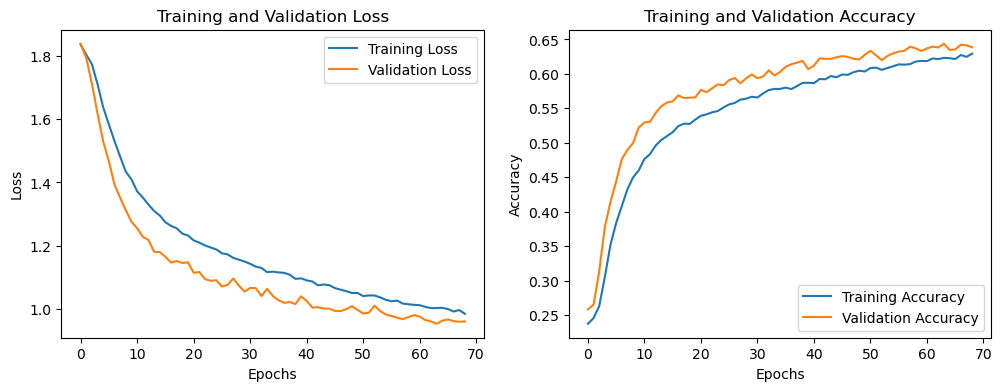

In [12]:
# Visualisera tränings- och valideringsförlust samt noggrannhet
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Skapa och kompilera en ny alternativ modell
Vi bygger en alternativ modell med Global Average Pooling istället för flattening. Denna modell kan vara mindre benägen att överträna på träningsdata.


In [14]:
# Skapa och kompilera en ny alternativ modell
alternative_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    # Lägg till Global Average Pooling direkt efter det fjärde Convolutional lagret
    GlobalAveragePooling2D(),

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

alternative_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                          loss='categorical_crossentropy', 
                          metrics=['accuracy'])



C:\Users\pauls\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Träna den alternativa modellen
Vi tränar den alternativa modellen med samma inställningar som den första för att kunna jämföra resultaten.


In [16]:
# Skapa en Early Stopping-callback
early_stopper = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Träna den alternativa modellen med Early Stopping
alternative_history = alternative_model.fit(train_data, 
                                            epochs=100, 
                                            validation_data=validation_data, 
                                            callbacks=[early_stopper])

# Spara den alternativa modellen
alternative_model.save('./models/alternative_emotion_detection_model.keras')

Epoch 1/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 95s 91ms/step - accuracy: 0.2195 - loss: 1.8664 - val_accuracy: 0.2583 - val_loss: 1.8690
Epoch 2/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 83s 92ms/step - accuracy: 0.2520 - loss: 1.8283 - val_accuracy: 0.2584 - val_loss: 1.8412
Epoch 3/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 77s 85ms/step - accuracy: 0.2417 - loss: 1.8075 - val_accuracy: 0.2594 - val_loss: 1.8057
Epoch 4/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 80s 88ms/step - accuracy: 0.2449 - loss: 1.7969 - val_accuracy: 0.2624 - val_loss: 1.8011
Epoch 5/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 76s 83ms/step - accuracy: 0.2505 - loss: 1.7863 - val_accuracy: 0.2920 - val_loss: 1.7914
Epoch 6/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 63s 69ms/step - accuracy: 0.2604 - loss: 1.7743 - val_accuracy: 0.3072 - val_loss: 1.7338
Epoch 7/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 58s 64ms/step - accuracy: 0.2833 - loss: 1.7485 - val_accuracy: 0.3256 - val_loss: 1.7069
Epoch 8/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 58s 65ms/step - accuracy: 0.2902 - loss: 1

### Visualisera tränings- och valideringsresultaten för den alternativa modellen
Här visualiserar vi träningshistoriken för den alternativa modellen och jämför den med den första modellen.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,264,919 (4.83 MB)

 Trainable params: 421,639 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 843,280 (3.22 MB)

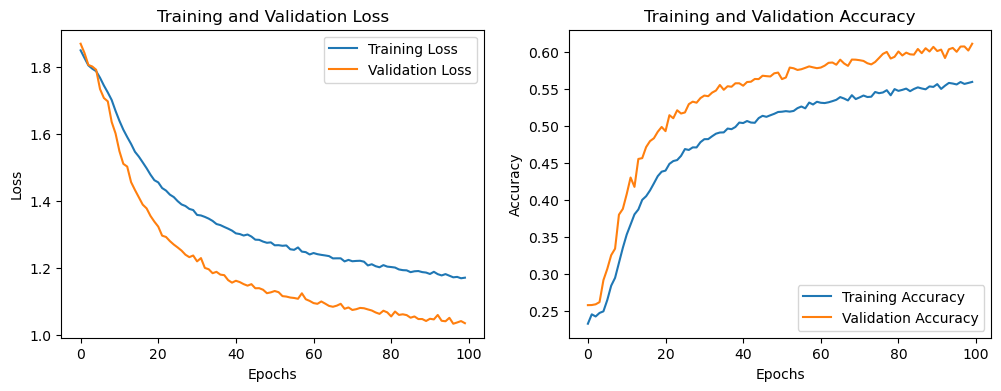

In [18]:
# Skriv ut en sammanfattning av den alternativa modellen
alternative_model.summary()

# Visualisera tränings- och valideringsresultaten för den alternativa modellen
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(alternative_history.history['loss'], label='Training Loss')
plt.plot(alternative_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(alternative_history.history['accuracy'], label='Training Accuracy')
plt.plot(alternative_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Jämför modellerna
Vi jämför prestandan för båda modellerna på tränings- och valideringsdata för att se vilken som fungerar bäst.


In [20]:
# Hämta prestandavärden för den första modellen
new_model = tf.keras.models.load_model('improved_emotion_detection_model.keras')
new_train_loss, new_train_accuracy = new_model.evaluate(train_data)
new_val_loss, new_val_accuracy = new_model.evaluate(validation_data)

# Hämta prestandavärden för den andra modellen
alt_train_loss, alt_train_accuracy = alternative_model.evaluate(train_data)
alt_val_loss, alt_val_accuracy = alternative_model.evaluate(validation_data)

# Skriv ut jämförelsen mellan de två modellerna
print("=== Comparison of Models ===")
print(f"First Model - Training Accuracy: {new_train_accuracy:.4f}, Training Loss: {new_train_loss:.4f}")
print(f"First Model - Validation Accuracy: {new_val_accuracy:.4f}, Validation Loss: {new_val_loss:.4f}")
print("----------------------------------------------------")
print(f"Second Model - Training Accuracy: {alt_train_accuracy:.4f}, Training Loss: {alt_train_loss:.4f}")
print(f"Second Model - Validation Accuracy: {alt_val_accuracy:.4f}, Validation Loss: {alt_val_loss:.4f}")

901/901 ━━━━━━━━━━━━━━━━━━━━ 60s 66ms/step - accuracy: 0.6618 - loss: 0.8935
221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.6482 - loss: 0.9464
901/901 ━━━━━━━━━━━━━━━━━━━━ 43s 48ms/step - accuracy: 0.6010 - loss: 1.0539
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.6095 - loss: 1.0261
=== Comparison of Models ===
First Model - Training Accuracy: 0.6621, Training Loss: 0.8952
First Model - Validation Accuracy: 0.6438, Validation Loss: 0.9537
----------------------------------------------------
Second Model - Training Accuracy: 0.6035, Training Loss: 1.0508
Second Model - Validation Accuracy: 0.6070, Validation Loss: 1.0336
